In [1]:
import sys, os, re
from glob import glob
from copy import deepcopy
sys.path.append('../BPhysics/lib')

import ROOT as rt
import numpy as np

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = 6*' ' + ' Internal'

from analysis_utilities import drawOnCMSCanvas
from histo_utilities import create_TH1D, std_color_list, SetMaxToMaxHist, make_ratio_plot

# Get pileup histograms

In [3]:
triggers = ['Mu7_IP4', 'Mu9_IP6', 'Mu12_IP6']
parts = [1,2,3,4,5]

In [4]:
hPU = {}
auxFiles = []
for trg in triggers:
    hPU[trg] = []
    for p in parts:
        f = rt.TFile.Open('pileupHistos/pileupHisto_{}_part{}.root'.format(trg, p), 'READ')
        auxFiles.append(f)
        h = f.Get('pileup')
        hPU[trg].append(h.Clone('h_'+trg+'_'+str(p)))

# Compare different parts

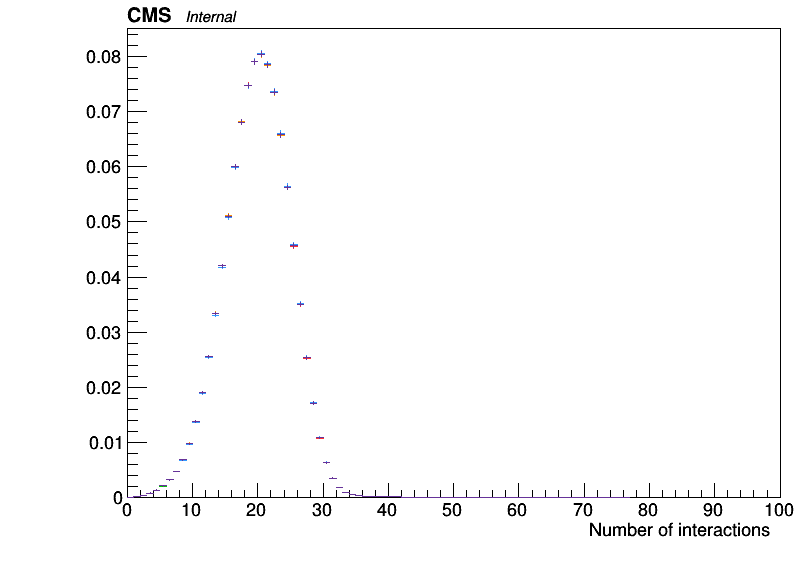

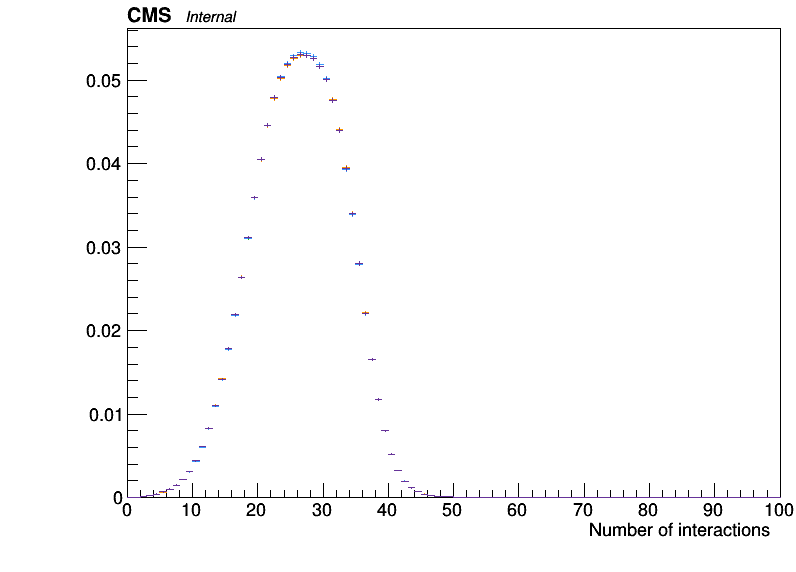

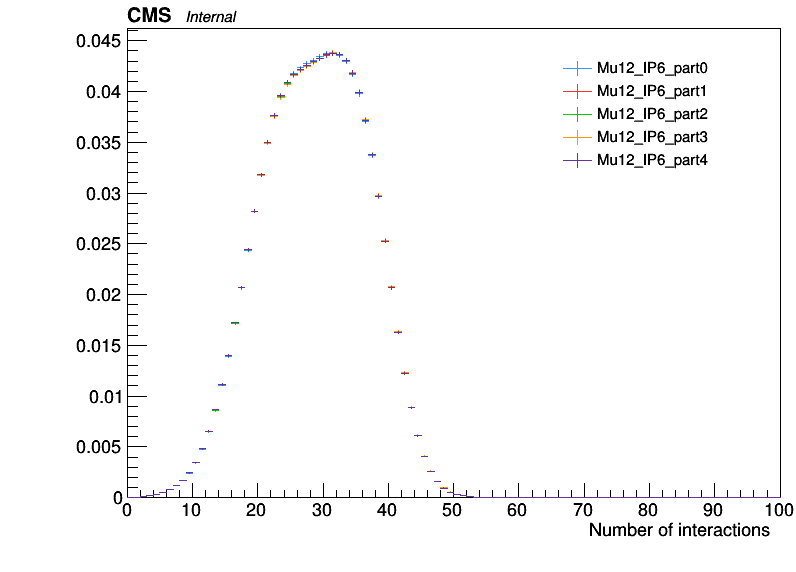

In [5]:
cOut = []

for trg in triggers:
    hList = deepcopy(hPU[trg])
    
    leg = rt.TLegend(0.7, 0.7, 0.9, 0.9)
    leg.SetTextFont(42)
    leg.SetTextAlign(12)
    leg.SetLineWidth(0)
    leg.SetBorderSize(0)
    
    # Recolor
    for i, (h, c) in enumerate(zip(hList, std_color_list)):
        h.SetLineColor(c)
        h.SetMarkerColor(c)
        h.Scale(1./h.Integral())
        leg.AddEntry(h, trg+'_part'+str(i), 'lep')
        
    hList[0].GetXaxis().SetTitle('Number of interactions')
    c = drawOnCMSCanvas(CMS_lumi, hList, 'same', tag=trg)
    leg.Draw()
    cOut.append(c)

# Create total pileup spectrum

In [6]:
expectedEvents ={'Mu7_IP4': 254., 'Mu9_IP6':631., 'Mu12_IP6':1012.}

tot = np.sum(expectedEvents.values())
for k in expectedEvents.keys():
    expectedEvents[k] /= float(tot)
    
print expectedEvents

{'Mu12_IP6': 0.5334739061676331, 'Mu9_IP6': 0.3326304691618345, 'Mu7_IP4': 0.13389562467053243}


In [7]:
hTot = {}

hs = rt.THStack('hStack','hStack')

leg = rt.TLegend(0.56, 0.35, 0.97, 0.9)
leg.SetTextFont(42)
leg.SetTextAlign(12)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

for i, trg in enumerate(triggers):
    hTrg = hPU[trg][0].Clone('h_'+trg)
    for h in hPU[trg][1:]:
        hTrg.Add(h)
    hTrg.Scale(expectedEvents[trg]/hTrg.Integral())
    hTrg.Sumw2(0)
    hTrg.SetLineColor(std_color_list[i])
    fAuxTrg = rt.TFile.Open('pileupHistos/'+trg+'_allParts.root', 'RECREATE')
    auxFiles.append(fAuxTrg)
    hTrg.Write()
    hTrg.SetFillColor(std_color_list[i])
    
    leg.AddEntry(hTrg, trg + ' (scaled to fraction of B cands.)', 'f')
    
    hTot[trg] = hTrg
    
    hs.Add(hTrg)

In [8]:
f_c0 = rt.TFile.Open('otherPileupHistos/histoPileup_c0.root', 'READ')
auxFiles.append(f_c0)
h_c0 = f_c0.Get('h')

h_c0.SetLineWidth(2)

h_c0.SetLineColor(std_color_list[len(triggers)])
h_c0.Scale(1./h_c0.Integral())
h_c0.Sumw2(0)

leg.AddEntry(h_c0, 'Custom c0 (pre-approval)', 'l')

<ROOT.TLegendEntry object ("TLegendEntry") at 0xa89f080>

In [9]:
f_full2018 = rt.TFile.Open('otherPileupHistos/pileup_2018_fromRiccardoManzoni_210409.root', 'READ')
auxFiles.append(f_full2018)
h_full2018 = f_full2018.Get('pileup_2018total')

h_full2018.SetLineWidth(2)

h_full2018.SetLineColor(std_color_list[len(triggers)+4])
h_full2018.Scale(1./h_full2018.Integral())
h_full2018.Sumw2(0)

leg.AddEntry(h_full2018, 'Total 2018 parking data', 'l')

<ROOT.TLegendEntry object ("TLegendEntry") at 0x184d670>

In [10]:
fOut = rt.TFile.Open('pileupHistos/pileupProfile_full2018.root', 'RECREATE')
h_full2018.Write()
fOut.Close()

In [11]:
hPo20 = create_TH1D(np.random.poisson(lam=20, size=100000),
                    'hPU20',
                    h2clone=h_c0,
                    scale_histo='norm')

hPo20.SetLineColor(std_color_list[len(triggers) + 1])
hPo20.Sumw2(0)
hPo20.GetXaxis().SetTitle('Number of interactions')

leg.AddEntry(hPo20, 'Poisson #lambda=20', 'l')

<ROOT.TLegendEntry object ("TLegendEntry") at 0x81f9a40>

In [12]:
hPo30 = create_TH1D(np.random.poisson(lam=30, size=100000),
                    'hPU30',
                    h2clone=h_c0,
                    scale_histo='norm')

hPo30.SetLineColor(std_color_list[len(triggers) + 3])
hPo30.Sumw2(0)

leg.AddEntry(hPo30, 'Poisson #lambda=30', 'l')

<ROOT.TLegendEntry object ("TLegendEntry") at 0x81ff550>

In [13]:
hList = hTot.values()
hFinal = hList[0].Clone('pileup_RDstOptimal')
for h in hList[1:]:
    hFinal.Add(h)
    
hFinal.SetLineColor(1)
hFinal.SetLineWidth(2)
hFinal.SetFillStyle(0)
leg.AddEntry(hFinal, 'Optimal for R(D*) analysis', 'l')
    
fOut = rt.TFile.Open('pileupHistos/pileupProfile_RDstOptimal.root', 'RECREATE')
hFinal.Write()
fOut.Close()

Info in <TCanvas::Print>: png file pileupSummaryComparison.png has been created


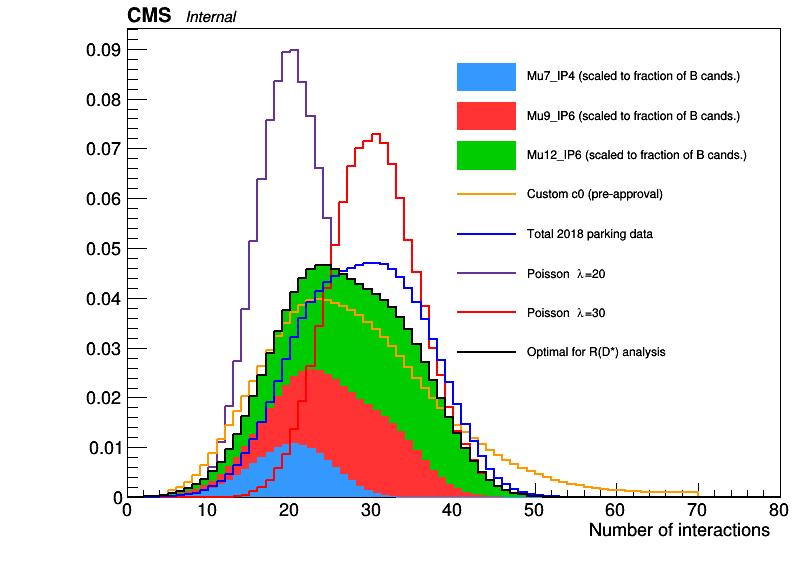

In [14]:
c = rt.TCanvas('c', 'c', 50, 50, 800, 600)
c.SetTickx(0)
c.SetTicky(0)

hPo20.Draw()

hs.Draw('same')
hs.GetXaxis().SetTitle('Number of interactions')
hs.GetYaxis().SetRangeUser(0, 1.)

h_c0.Draw('same')
hPo30.Draw('same')

h_full2018.Draw('same')
hFinal.Draw('same')

leg.Draw()

CMS_lumi.CMS_lumi(c, -1, 0)
c.Draw()
c.SaveAs('pileupSummaryComparison.png')

In [15]:
std_color_list

[861, 628, 417, 797, 873, 1, 2, 4, 8, 6, 28, 43, 7, 25, 1]